# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

Starting from: https://github.com/squillero/computational-intelligence/blob/master/2024-25/set-cover.ipynb

Solve efficiently these instances customizing a technique discussed in class:
| Instance | Universe size | Num sets | Density |
|----------|---------------|----------|---------|
| 1        | 100           | 10       | 0.2     |
| 2        | 1,000         | 100      | 0.2     |
| 3        | 10,000        | 1,000    | 0.2     |
| 4        | 100,000       | 10,000   | 0.1     |
| 5        | 100,000       | 10,000   | 0.2     |
| 6        | 100,000       | 10,000   | 0.3     |

I tried using simulated annealing technique to solve the problem. Basically is Hill Climbing with a probability p != 0 of accepting a worsening solution s', where f(s) > f(s'):

$$ p = e^{-\frac{f(s) - f(s')}{t}} $$

f stands for the fitness of the solution.

In [17]:
from random import random, seed
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from itertools import accumulate
from tqdm.auto import tqdm
from icecream import ic
from concurrent.futures import ThreadPoolExecutor, as_completed

#print(f"Ottimizzazione: {sys.flags.optimize}")

## Initialization

In [18]:
#parameters for instances
USIZES_LIST = [100, 1000, 10000, 100000, 100000, 100000]
NSETS_LIST = [10, 100, 1000, 10000, 10000, 10000]
DENSITIES_LIST = [.2, .2, .2, .1, .2, .3]

In [19]:
UNIVERSE_SIZE = None
NUM_SETS = None
#probability that an element belongs to a set
DENSITY = None 

SETS = None
COSTS = None

In [20]:
# DON'T EDIT THESE LINES! --> 
# I wrapped the code inside a function in order to be runned again for the number of instances defined in the problem

def create_and_define_sets():
    global SETS, COSTS
    SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
    for s in range(UNIVERSE_SIZE):
        if not np.any(SETS[:, s]):
            SETS[np.random.randint(NUM_SETS), s] = True
    COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [21]:
# solution represents which sets have been selected

def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    phenotype = np.logical_or.reduce(SETS[solution])
    return np.all(phenotype)

def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

In [22]:
def tweak(solution):
    # Define a new solution
    mask = np.random.random(NUM_SETS) < 0.01
    new_solution = np.logical_xor(solution, mask)
    return new_solution

""" The goal is to minimize the cost, but at the same time solution HAS TO BE VALID!!"""
def fitness(solution: np.ndarray):
    return (valid(solution), -cost(solution))

# WHY cost is returned negative:
# (0, -100) > (0, -500)
# (1, -100) > (1, -500) --> I want this condition: the goal is to minimize cost, but at the same time solution has to be valid!

## Simulated Annealing

In [23]:
MAX_ITERATIONS = 1000

# For every istance execute 4 times simulated annealing
TEMPS = [7000, 12500, 17000, 25000]
COOLING_RATE = 0.985

MIN_TEMP = 1e-17    #could be changed to avoid overflow

In [29]:
def simulated_annealing(initial_solution, initial_temp):
    """simulated annealing implementation"""
    best_solution = initial_solution.copy()
    fitness_solution = fitness(best_solution)
    history = [fitness_solution[1]]  

    temperature = initial_temp

    for _iteration in tqdm(range(MAX_ITERATIONS)):

        new_solution = tweak(best_solution)
        f = fitness(new_solution)
        history.append(f[1]) 

        if f[0]:    #if solution is valid

            new_cost = -f[1]
            cost_diff = new_cost - (-fitness_solution[1])

            # If new_cost is better change solution, otherwise use probability to accept a worse solution
            # Accepting worsening solution? 0 < e^(-x) <= 1
            if cost_diff < 0 or np.random.random() < np.exp(-cost_diff / temperature):
                best_solution = new_solution.copy()
                fitness_solution = fitness(best_solution)

        if temperature > MIN_TEMP:
            # Reduce temperature
            temperature *= COOLING_RATE

    #print(f"Final Temperature: {temperature}")

    return best_solution, -fitness_solution[1], history, initial_temp


def run_simulations(initial_solution, num_simulations=4):
    """Run simulated annealing in parallel"""
    results = []
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(simulated_annealing, initial_solution, TEMPS[i])
                   for i in range(num_simulations)]
        
        # as_completed(future) is responsible for result management
        for future in tqdm(as_completed(futures), total=num_simulations):
            results.append(future.result())
    
    # Choose the best solution from all simulations
    best_run = min(results, key=lambda x: x[1])  # Assuming we're minimizing the cost
    return best_run

## Trials

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Best solution cost: 301.41089319790115
Is the solution valid? Yes
Numbers of subsets: 10
Usign initial temperature: 17000


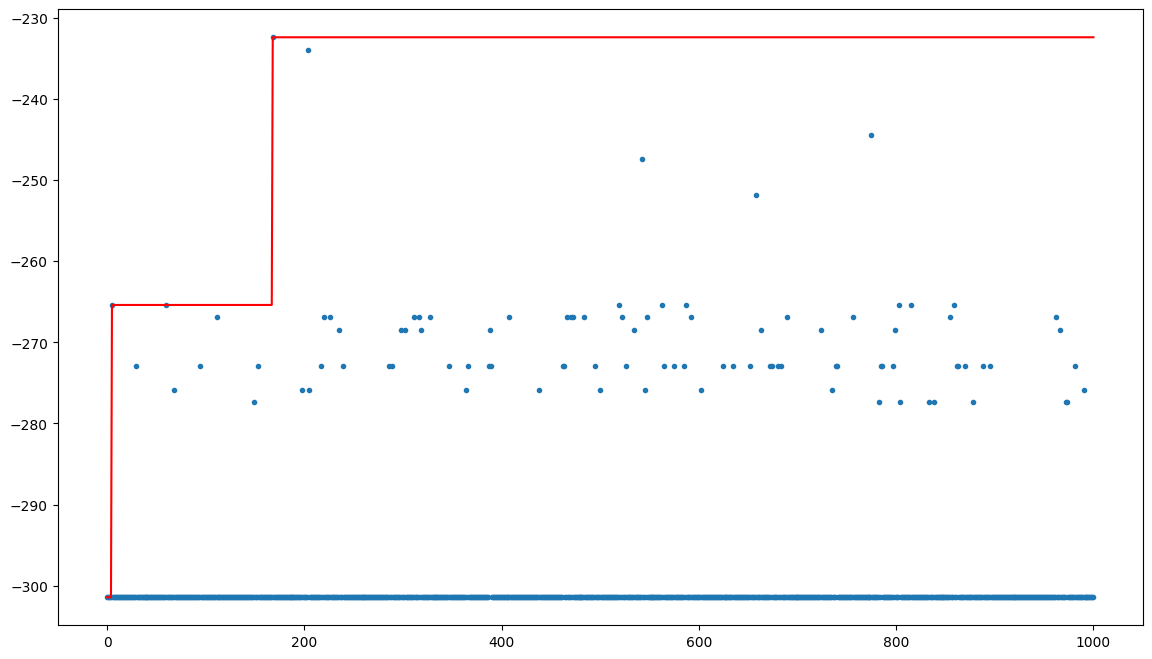

In [30]:
""" Instance: 1"""
UNIVERSE_SIZE = USIZES_LIST[0]
NUM_SETS = NSETS_LIST[0]
DENSITY = DENSITIES_LIST[0] 

create_and_define_sets()

initial_solution = np.full(NUM_SETS, True)  # Starting from an always valid solution?

best_solution, best_cost, history, initial_temp = run_simulations(initial_solution)

print(f"Best solution cost: {best_cost}")
print(f"Is the solution valid? {'Yes' if valid(best_solution) else 'No'}")
print(f"Numbers of subsets: {np.count_nonzero(best_solution)}")
print(f"Usign initial temperature: {initial_temp}")

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),     #plot max cost at each step
    color="red"
)
_ = plt.scatter(range(len(history)), history, marker=".")

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Best solution cost: 6842.383862045828
Is the solution valid? Yes
Numbers of subsets: 20
Usign initial temperature: 25000


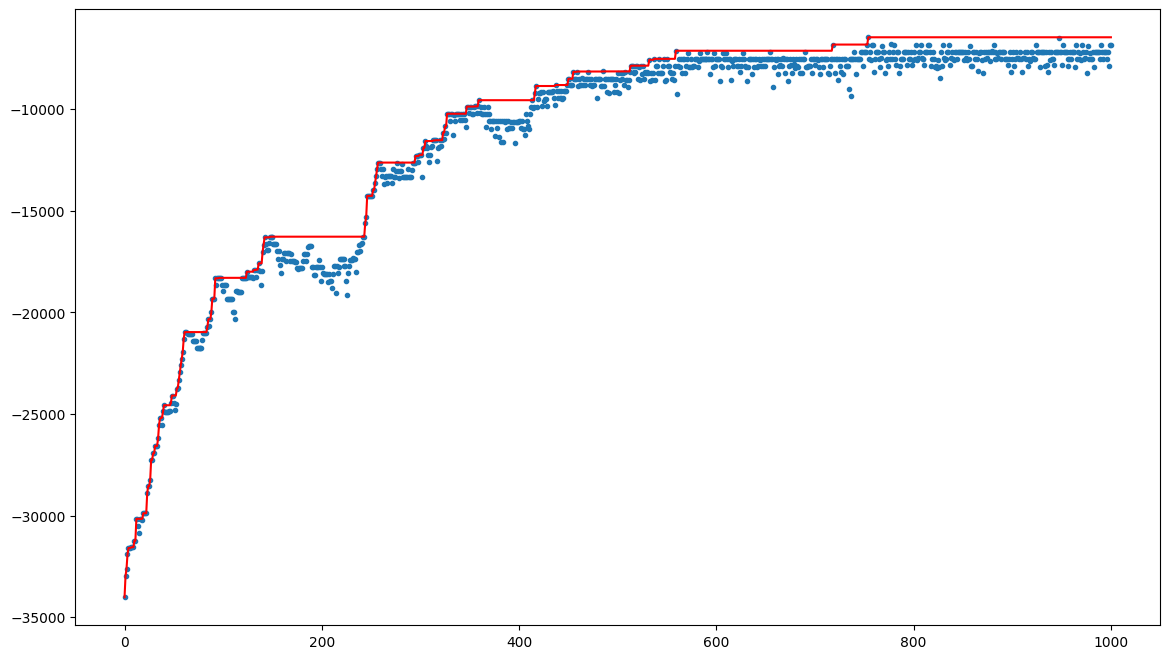

In [34]:
""" Instance: 2"""
UNIVERSE_SIZE = USIZES_LIST[1]
NUM_SETS = NSETS_LIST[1]
DENSITY = DENSITIES_LIST[1] 

create_and_define_sets()

initial_solution = np.full(NUM_SETS, True)  # Starting from an always valid solution?

best_solution, best_cost, history, initial_temp = run_simulations(initial_solution)

print(f"Best solution cost: {best_cost}")
print(f"Is the solution valid? {'Yes' if valid(best_solution) else 'No'}")
print(f"Numbers of subsets: {np.count_nonzero(best_solution)}")
print(f"Usign initial temperature: {initial_temp}")

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),     #plot max cost at each step
    color="red"
)
_ = plt.scatter(range(len(history)), history, marker=".")

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Best solution cost: 1147787.8210480367
Is the solution valid? Yes
Numbers of subsets: 269
Usign initial temperature: 7000


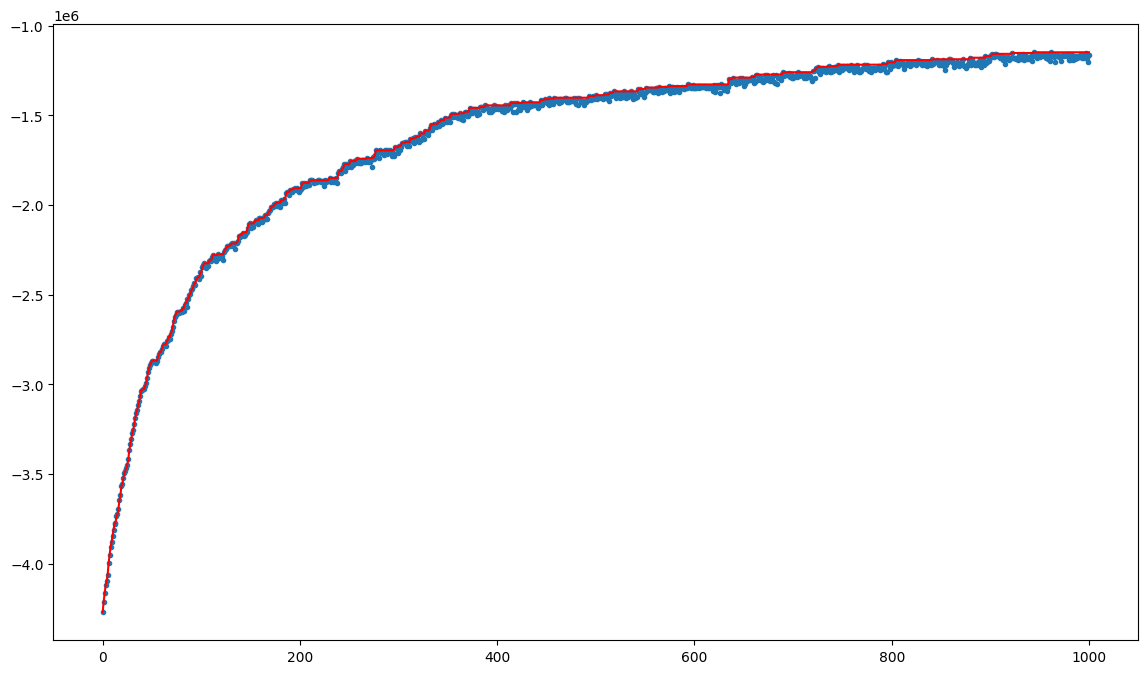

In [36]:
""" Instance: 3"""
UNIVERSE_SIZE = USIZES_LIST[2]
NUM_SETS = NSETS_LIST[2]
DENSITY = DENSITIES_LIST[2] 

create_and_define_sets()

initial_solution = np.full(NUM_SETS, True)  # Starting from an always valid solution?

best_solution, best_cost, history, initial_temp = run_simulations(initial_solution)

print(f"Best solution cost: {best_cost}")
print(f"Is the solution valid? {'Yes' if valid(best_solution) else 'No'}")
print(f"Numbers of subsets: {np.count_nonzero(best_solution)}")
print(f"Usign initial temperature: {initial_temp}")

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),     #plot max cost at each step
    color="red"
)
_ = plt.scatter(range(len(history)), history, marker=".")

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Best solution cost: 105649574.6579897
Is the solution valid? Yes
Numbers of subsets: 4207
Usign initial temperature: 7000


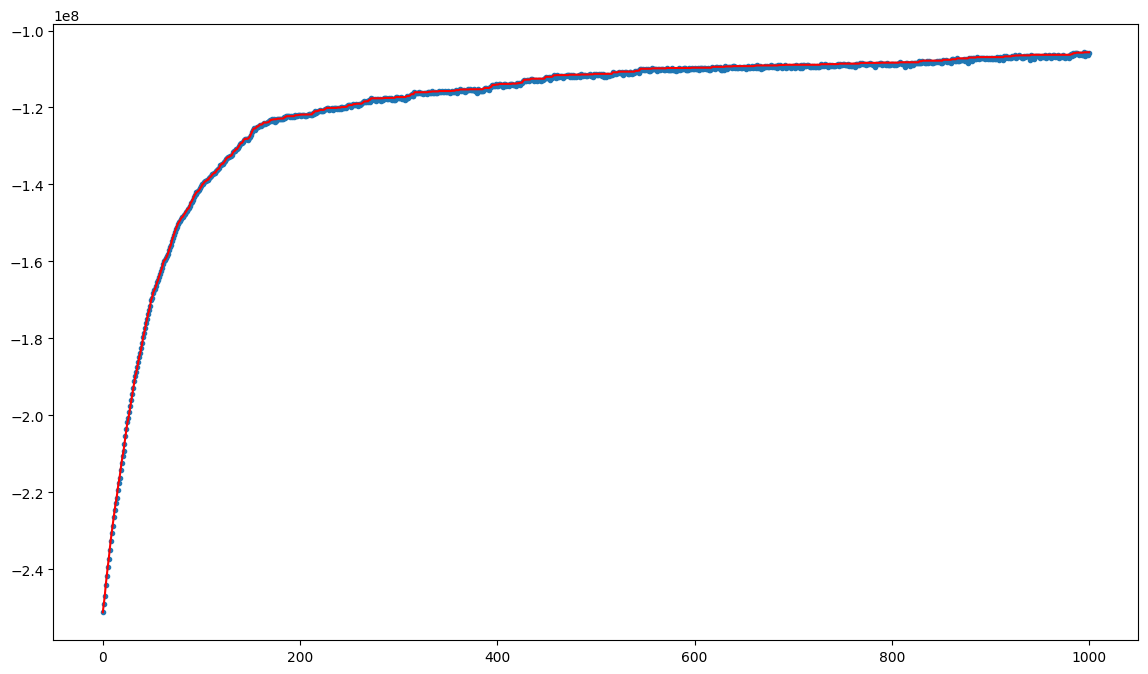

In [38]:
""" Instance: 4"""
UNIVERSE_SIZE = USIZES_LIST[3]
NUM_SETS = NSETS_LIST[3]
DENSITY = DENSITIES_LIST[3] 

create_and_define_sets()

initial_solution = np.full(NUM_SETS, True)  # Starting from an always valid solution?

best_solution, best_cost, history, initial_temp = run_simulations(initial_solution)

print(f"Best solution cost: {best_cost}")
print(f"Is the solution valid? {'Yes' if valid(best_solution) else 'No'}")
print(f"Numbers of subsets: {np.count_nonzero(best_solution)}")
print(f"Usign initial temperature: {initial_temp}")

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),     #plot max cost at each step
    color="red"
)
_ = plt.scatter(range(len(history)), history, marker=".")

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Best solution cost: 227435351.39098784
Is the solution valid? Yes
Numbers of subsets: 4225
Usign initial temperature: 7000


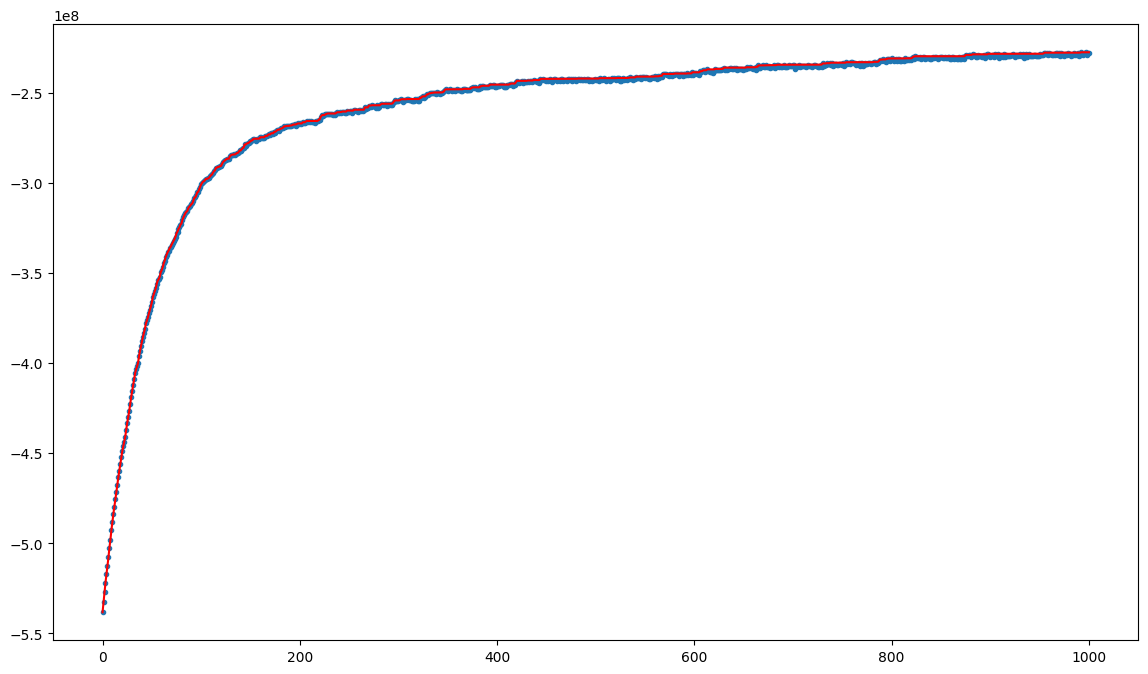

In [39]:
""" Instance: 5"""
UNIVERSE_SIZE = USIZES_LIST[4]
NUM_SETS = NSETS_LIST[4]
DENSITY = DENSITIES_LIST[4] 

create_and_define_sets()

initial_solution = np.full(NUM_SETS, True)  # Starting from an always valid solution?

best_solution, best_cost, history, initial_temp = run_simulations(initial_solution)

print(f"Best solution cost: {best_cost}")
print(f"Is the solution valid? {'Yes' if valid(best_solution) else 'No'}")
print(f"Numbers of subsets: {np.count_nonzero(best_solution)}")
print(f"Usign initial temperature: {initial_temp}")

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),     #plot max cost at each step
    color="red"
)
_ = plt.scatter(range(len(history)), history, marker=".")

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Best solution cost: 354687657.1795525
Is the solution valid? Yes
Numbers of subsets: 4217
Usign initial temperature: 25000


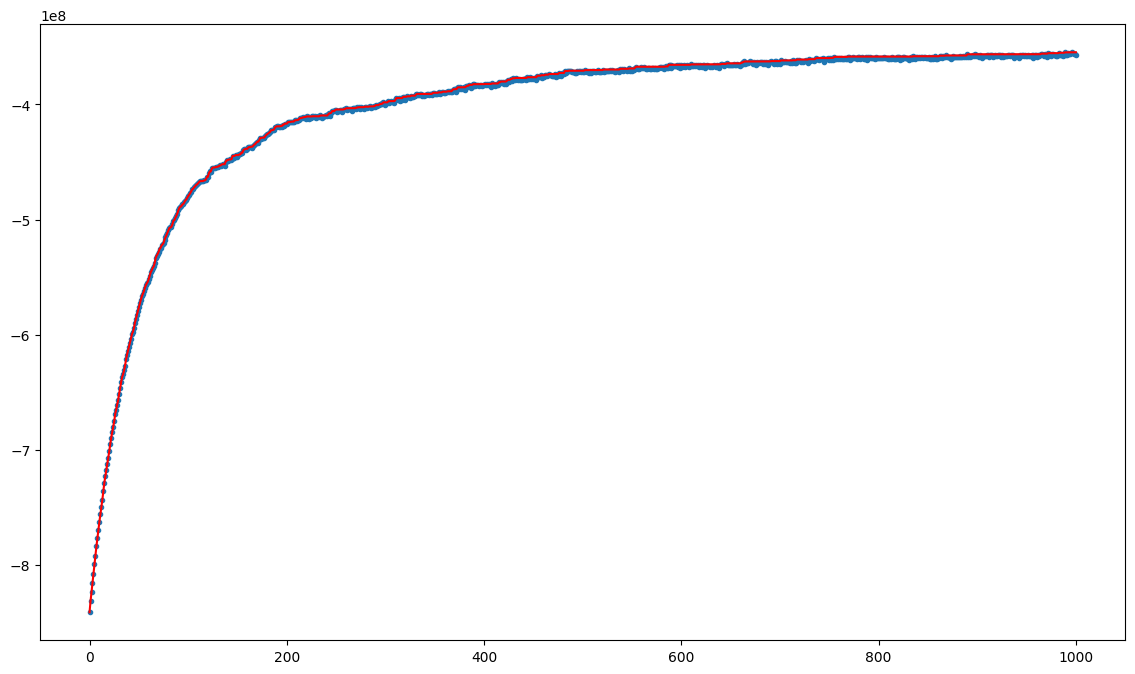

In [40]:
""" Instance: 6"""
UNIVERSE_SIZE = USIZES_LIST[5]
NUM_SETS = NSETS_LIST[5]
DENSITY = DENSITIES_LIST[5] 

create_and_define_sets()

initial_solution = np.full(NUM_SETS, True)  # Starting from an always valid solution?

best_solution, best_cost, history, initial_temp = run_simulations(initial_solution)

print(f"Best solution cost: {best_cost}")
print(f"Is the solution valid? {'Yes' if valid(best_solution) else 'No'}")
print(f"Numbers of subsets: {np.count_nonzero(best_solution)}")
print(f"Usign initial temperature: {initial_temp}")

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),     #plot max cost at each step
    color="red"
)
_ = plt.scatter(range(len(history)), history, marker=".")